In [ ]:
!python -m pip install -qq kaggle

In [ ]:
%%bash
mkdir ~/.kaggle                                                                 #
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle datasets download nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
unzip -qq "/content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip"
mv "CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone" "ct_kidney_dataset"
mv "ct_kidney_dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone" "CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
rm -rf "sample_data" "ct_kidney_dataset"
mv "CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone" "ct_kidney_dataset"

100%|██████████| 1.52G/1.52G [00:15<00:00, 106MB/s]


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import matplotlib.pyplot as plt

In [ ]:
# load data csv file as dataframe
metadata=pd.read_csv('kidneyData.csv').drop(columns=['Unnamed: 0'])             # load data and drop old indexs
metadata.head()
                                                     # see first five rows

,image_id,path,diag,target,Class
0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [ ]:
class_labels_dict=metadata.groupby('Class')[['target']].aggregate('mean').astype('uint8').to_dict()['target']
class_labels=class_labels_dict.keys()

In [ ]:
classes=os.listdir('ct_kidney_dataset')                                                  # get all classes names
print('Total classes:',len(classes))                                            # total classes
print('Class names:',classes)                                                   # class names
# clean class names
classes_clean=[re.sub('[^A-Za-z0-9 ]',' ',class_) for class_ in classes]        # remove unwanted characters
classes_clean=[re.sub('[ ]+','_',class_).casefold() for class_ in classes_clean]# replace one or multiple spaces by underscore '_'
print('Cleaned Class names:',classes_clean)                                     # clean class names
# rename class names with clean class names
for old_name,new_name in zip(classes,classes_clean):                            # get old and new class names
  os.rename(os.path.join('ct_kidney_dataset',old_name),os.path.join('ct_kidney_dataset',new_name))# rename with new class names
# get minimum class count ------------------------------------------------------
class_counts:dict=dict()                                                        # get class samples for each class
# get number of files in each class
for class_ in os.listdir('ct_kidney_dataset'):                                           # get class name folder
  class_counts[class_]=len(os.listdir(os.path.join('ct_kidney_dataset',class_)))         # count samples in given class
print('Class counts:',class_counts)                                             # print class counts
minimum_class_count=min(class_counts.values())                                  # get minimum class count
test_split_size:int=int(minimum_class_count*10/100)                             # get test split size
# make train and test directory
os.mkdir('test')                                                                # make directory to store test data
# move 10% of minimum class count from each directory
for class_ in os.listdir('ct_kidney_dataset'):
  os.mkdir(os.path.join('test',class_))                                         # make folder in test directory
  # make move randomly selected images from main to test directory
  for image in np.random.choice(os.listdir(os.path.join('ct_kidney_dataset',class_)),replace=False,size=test_split_size):# get image by image
    os.rename(os.path.join('ct_kidney_dataset',class_,image),os.path.join('test',class_,image))# make move image
os.rename('ct_kidney_dataset','train')                                                   # rename main directory as train

Total classes: 4
Class names: ['Stone', 'Normal', 'Cyst', 'Tumor']
Cleaned Class names: ['stone', 'normal', 'cyst', 'tumor']
Class counts: {'stone': 1377, 'normal': 5077, 'cyst': 3709, 'tumor': 2283}


In [ ]:
# load dataset - train, test and valid
train=tf.keras.utils.image_dataset_from_directory('train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(192,192),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='training',seed=8,)
valid=tf.keras.utils.image_dataset_from_directory('train',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                  batch_size=32,image_size=(192,192),shuffle=True,validation_split=0.3,
                                                  interpolation='bilinear',subset='validation',seed=8,)
test=tf.keras.utils.image_dataset_from_directory('test',labels='inferred',label_mode='int',class_names=None,color_mode='rgb',
                                                 batch_size=32,image_size=(192,192),shuffle=False,validation_split=0.0,
                                                 interpolation='bilinear',subset=None,seed=8,)
print('Total training images:',train.cardinality()*32)
print('Total validation images:',valid.cardinality()*32)
print('Total test images:',test.cardinality()*32)
training_classes:list=train.class_names
valid_classses:list=valid.class_names
test_classes:list=test.class_names
assert training_classes==valid_classses==test_classes,'class count in train, valid and test set is not same'
print('Class names:',training_classes)

Found 11898 files belonging to 4 classes.
Using 8329 files for training.
Found 11898 files belonging to 4 classes.
Using 3569 files for validation.
Found 548 files belonging to 4 classes.
Total training images: tf.Tensor(8352, shape=(), dtype=int64)
Total validation images: tf.Tensor(3584, shape=(), dtype=int64)
Total test images: tf.Tensor(576, shape=(), dtype=int64)
Class names: ['cyst', 'normal', 'stone', 'tumor']


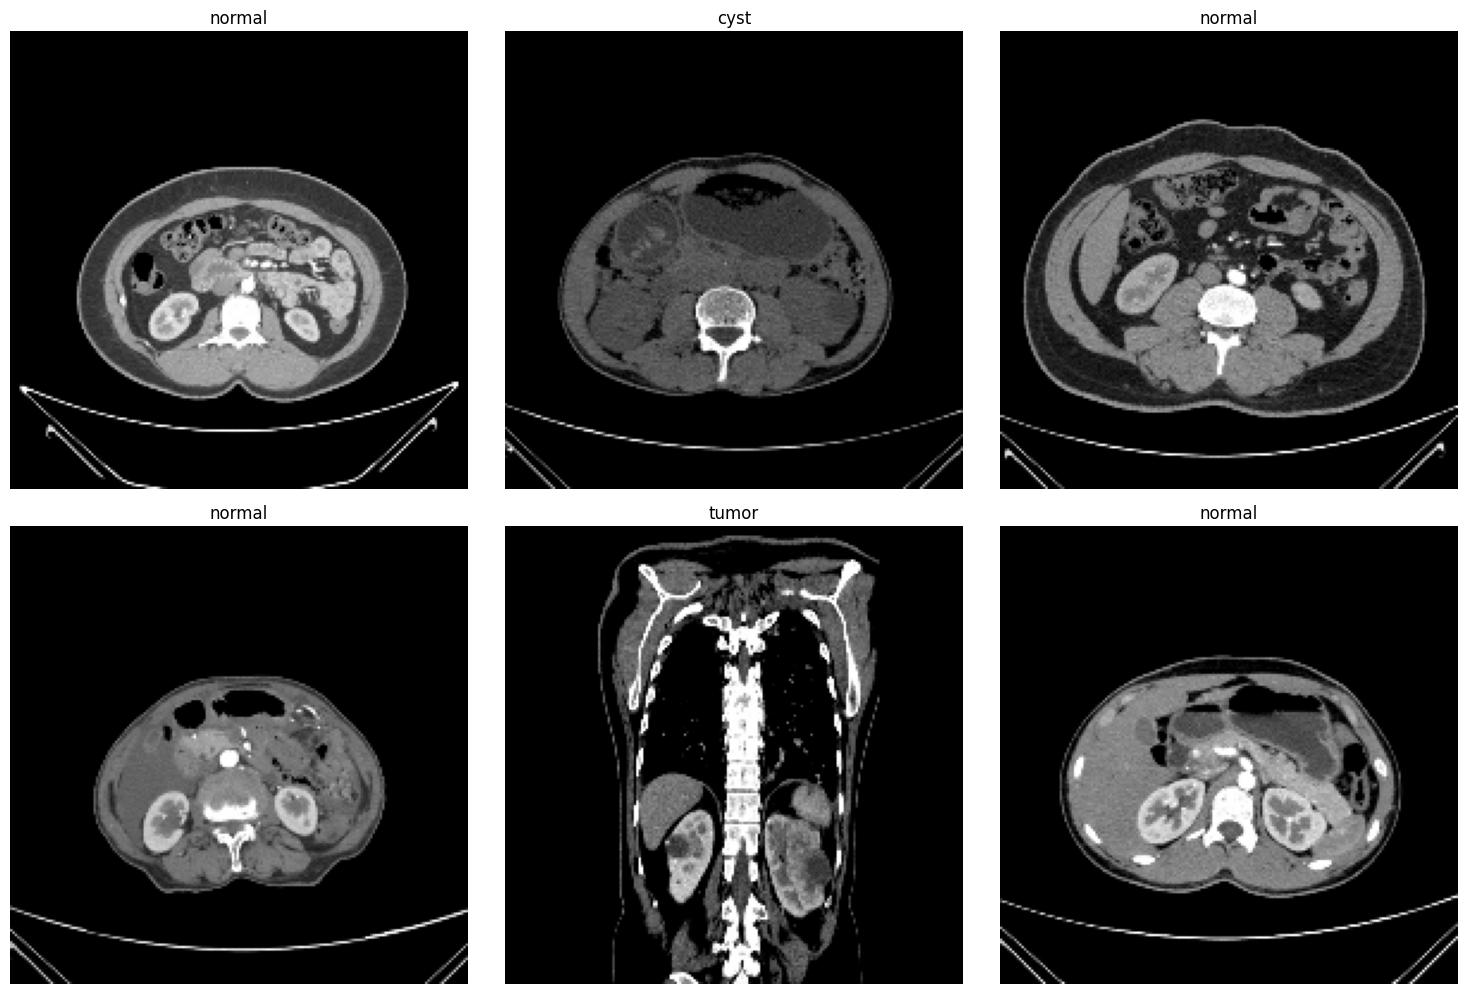

In [ ]:
# make plot data training data
for images,labels in train.take(1):break                                        # get a batch of data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(15,15))                                                     # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()                                                                      # make plot show

In [ ]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)

Maximum pixel values: tf.Tensor(255.0, shape=(), dtype=float32)
Minimum pixel values: tf.Tensor(0.0, shape=(), dtype=float32)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'float32'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int32'>


In [ ]:
# make apply data augmentation to data (add more randomness to data)
# source: https://www.tensorflow.org/tutorials/images/data_augmentation
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')# random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')# random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')          # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')# random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]         # make list of data augmentation
# make apply augmentation on training data
for augmentation in augmentations:  train.map(lambda images,labels: (augmentation(images),labels))                # make apply augmentation

In [ ]:
base_model=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(192,192,3),alpha=1.0,include_top=False,
                                                          weights='imagenet',input_tensor=None,pooling=None,classes=1000,                                                          classifier_activation='softmax')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs=tf.keras.layers.Input(shape=(192,192,3),batch_size=None,name='model_inputs')
model_x=tf.keras.layers.Rescaling(1./255,offset=0.0,name='rescaler')(inputs)
model_x=base_model(model_x)
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_mobilenetV2')
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None)

Model: "custom_mobilenetV2"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 model_inputs (InputLayer)                            [(None, 192, 192, 3)]                           0                 Y          
                                                                                                                                   
 rescaler (Rescaling)                                 (None, 192, 192, 3)                             0                 Y          
                                                                                                                                   
 mobilenetv2_1.00_192 (Functional)                    (None, 6, 6, 1280)                              2257984           Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [ ]:
# make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=10,verbose=1,mode='auto',restore_best_weights=True)

# make train model
history=model.fit(train,batch_size=32,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=valid,
                  shuffle=True)

Epoch 1/10000
261/261 - 105s - loss: 0.8408 - sparse_categorical_accuracy: 0.8935 - val_loss: 23.9029 - val_sparse_categorical_accuracy: 0.4749 - 105s/epoch - 404ms/step
Epoch 2/10000
261/261 - 46s - loss: 0.1244 - sparse_categorical_accuracy: 0.9690 - val_loss: 5.4070 - val_sparse_categorical_accuracy: 0.7089 - 46s/epoch - 177ms/step
Epoch 3/10000
261/261 - 46s - loss: 0.1394 - sparse_categorical_accuracy: 0.9659 - val_loss: 37.6985 - val_sparse_categorical_accuracy: 0.4222 - 46s/epoch - 176ms/step
Epoch 4/10000
261/261 - 46s - loss: 0.1333 - sparse_categorical_accuracy: 0.9689 - val_loss: 23.2729 - val_sparse_categorical_accuracy: 0.4469 - 46s/epoch - 175ms/step
Epoch 5/10000
261/261 - 48s - loss: 0.1207 - sparse_categorical_accuracy: 0.9727 - val_loss: 6.0577 - val_sparse_categorical_accuracy: 0.7083 - 48s/epoch - 182ms/step
Epoch 6/10000
261/261 - 47s - loss: 0.0433 - sparse_categorical_accuracy: 0.9902 - val_loss: 25.9508 - val_sparse_categorical_accuracy: 0.5721 - 47s/epoch - 179

In [ ]:
# see model history (first five epoches)
pd.DataFrame(history.history).head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,0.840820,0.893505,23.902920,0.474923
1,0.124449,0.969024,5.407047,0.708882
2,0.139397,0.965902,37.698479,0.422247
3,0.133276,0.968904,23.272854,0.446904
4,0.120659,0.972746,6.057711,0.708322


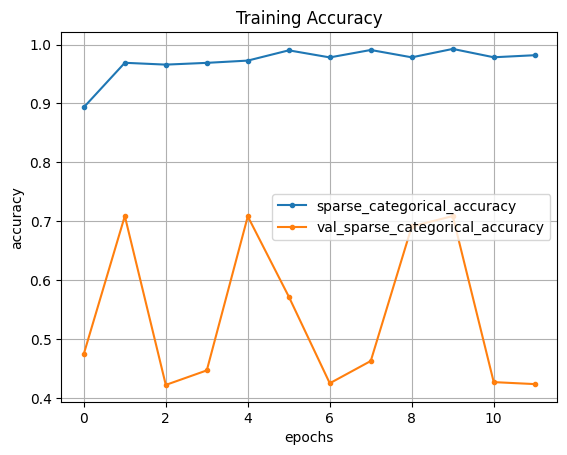

In [ ]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')# make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')# add grid, title and axis labels
plt.show()                                                                      # make plot showv

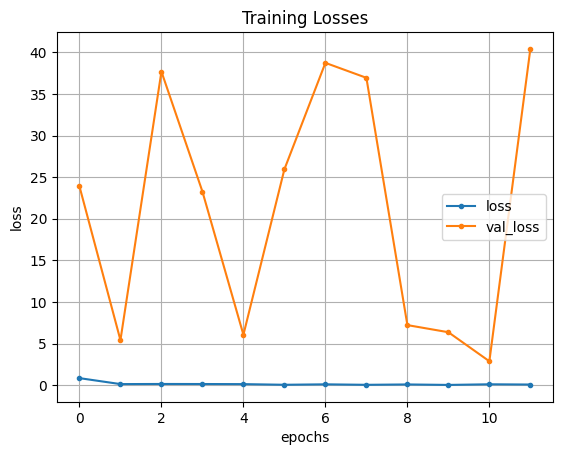

In [ ]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()                                                                      # make plot show

In [ ]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

18/18 [==============================] - 2s 123ms/step - loss: 7.7834 - sparse_categorical_accuracy: 0.5894
Testing results: {'loss': 7.783393859863281, 'sparse_categorical_accuracy': 0.5894160866737366}


In [ ]:
# make save model (weights and configuration)
model.save('ct_kidney_normal_cyst_tumor_and_stone',overwrite=True,save_format=None)               # make save

In [ ]:
!zip -r -qq "ct_kidney_normal_cyst_tumor_and_stone.zip" "ct_kidney_normal_cyst_tumor_and_stone"                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('ct_kidney_normal_cyst_tumor_and_stone.zip')                                       # download model zip file